In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from RS.core import *
from RS.model import *
from fastai.vision.all import *
from mmseg.models import build_segmentor
from mmcv.utils import Config
import tqdm

4 folder

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
imgs=get_files('/home/staff/xin/Downloads/tianchi/train/',extensions='.tif')

In [ ]:
kf = KFold(n_splits=4,shuffle=True)

In [ ]:
idx=0
for train_index, test_index in kf.split(imgs):
    df=pd.DataFrame({'path':imgs[train_index]})
    df['valid']=0
    df2=pd.DataFrame({'path':imgs[test_index]})
    df2['valid']=1
    df=df.append(df2)
    for i in range(len(df)):
        df.iloc[i,0]=str(df.iloc[i,0]).replace('/home/staff/xin/Downloads/tianchi/','/home/user/robeson/fastai2/')
    df.to_csv('./datafolder/'+str(idx)+'.csv',index=False)
    idx=idx+1

In [ ]:
df

,path,valid
0,/home/user/robeson/fastai2/train/003103.tif,0
1,/home/user/robeson/fastai2/train/002664.tif,0
2,/home/user/robeson/fastai2/train/002469.tif,0
3,/home/user/robeson/fastai2/train/005869.tif,0
4,/home/user/robeson/fastai2/train/005472.tif,0
...,...,...
4000,/home/user/robeson/fastai2/train/001432.tif,1
4001,/home/user/robeson/fastai2/train/012857.tif,1
4002,/home/user/robeson/fastai2/train/001937.tif,1
4003,/home/user/robeson/fastai2/train/001232.tif,1


In [ ]:
torch.cuda.set_device(1)

In [ ]:
class HRNET(nn.Module):
    def __init__(self,cfgfile):
        super().__init__()
        cfg = Config.fromfile(cfgfile)
        temp=build_segmentor(cfg.model)
        self.backbone =temp.backbone
        self.decode_head = temp.decode_head
    def forward(self, x):
#         x=F.upsample_bilinear(x,scale_factor=2)
        x = self.backbone(x)
        x = self.decode_head(x)
        return x

In [ ]:

model=HRNET(cfgfile='./fcn_hr18.py')

In [ ]:
stats=torch.load('./models/hrnet.pth')
model.load_state_dict(stats)

<All keys matched successfully>

In [ ]:
model=model.cuda().eval()

In [ ]:
imgs=get_files('/home/staff/xin/Downloads/tianchi/train/',extensions='.tif')

In [ ]:
weights=[]
for img in tqdm.tqdm(imgs):
    temp=RsImage.create(img)
    temp=val_pipe(image=temp.numpy())['image']
    with torch.no_grad():
        result=model(temp.unsqueeze(0).cuda())
    weights.append(result[3][0].cpu())

100%|██████████| 16017/16017 [08:58<00:00, 29.73it/s]


In [ ]:
len(weights)

16017

In [ ]:
dis=nn.PairwiseDistance(p=2)

In [ ]:
imgs2=get_files('/home/staff/xin/Downloads/tianchi/test/',extensions='.tif')

In [ ]:
path1=[]
path2=[]
for img in tqdm.tqdm(imgs2):
    temp=RsImage.create(img)
    temp=val_pipe(image=temp.numpy())['image']
    with torch.no_grad():
        result=model(temp.unsqueeze(0).cuda())
    minmax=torch.zeros(16017)
    for i in range(16017):
        ss=dis(weights[i].unsqueeze(0),result[3].cpu()).mean()
        minmax[i]=ss
    path1.append(img)
    path2.append(imgs[minmax.argmin()])
#     break

100%|██████████| 3000/3000 [1:06:24<00:00,  1.33s/it]


In [ ]:
newdf=pd.DataFrame({'path1':path1,'path2':path2
    
})

In [ ]:
newdf.to_csv('same.csv',index=False)

In [ ]:
def mIOU( pred,label, num_classes=10,scale=4):
    pred =F.upsample_bilinear(pred,scale_factor=scale)  
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    
    iou_list = list()
    present_iou_list = list()
    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        if sem_class!=30:
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else: 
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)
#     print(present_iou_list)
    return np.mean(present_iou_list)

In [ ]:
ious=[]
for img in tqdm.tqdm(path2):
    temp=RsImage.create(img)
    label=RsMask.create(str(img).replace('tif','png'))
    temp=val_pipe(image=temp.numpy(),mask=label.numpy())
    temp,bb=temp['image'],temp['mask']
    with torch.no_grad():
        result=model(temp.unsqueeze(0).cuda())
#     result =F.upsample_bilinear(result,scale_factor=4)
#     result=F.softmax(result)
#     result=result.argmax(axis=1)
    ious.append(mIOU(result,bb))

100%|██████████| 3000/3000 [01:39<00:00, 30.15it/s]


In [ ]:
np.mean(ious)

0.45765883444868033

In [ ]:
mIOU(result,bb)

[]


nan

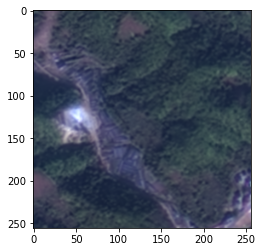

In [ ]:
RsImage.create(img).show()